# Tradeoff Problem Example: Podracing

We are entered in the race of the century! Just like Anakin Skywalker, we built our own podracer and are about to begin the race. The official informs us that there are certain “checkpoints” that we need to hit. Our goal is to save as much fuel as possible so we don’t run out during the race.

Before we start the race, we must figure out the appropriate thruster burns at each instant.
 * We’ll (approximately) model thrust as a 2D vector containing info on direction change
 * Amount of fuel we consume when we use thrusters is calculated as $L_2$ norm of thrust vector
 * Suppose the officials aren’t watching the checkpoints very closely, so long as we “sort of” hit the checkpoints we’ll be okay

In [6]:
using JuMP, Gurobi

k = 4              # number of checkpoints
T = zeros(Int,k)   # vector of timepoints
xw = zeros(2,k)    # vector of checkpoint locations

# times at which we must hit checkpoints
T[1] = 1
T[2] = 20
T[3] = 50
T[4] = 60

# define checkpoints' x and y coords
way_xy = [ 1   4   6   1
           1   3   0   1 ]

# create a function that takes a value for λ then solves and reports solution of tradeoff problem
function solveOpt(λ)
    
    m = Model(Gurobi.Optimizer) # need Gurobi since it's nonlinear
    
    @variable(m, x[1:2,1:T[k]])  # position at each time
    @variable(m, v[1:2,1:T[k]])  # velocity at each time
    @variable(m, u[1:2,1:T[k]])  # thruster input at each time

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== [0;0])
    @constraint(m, x[:,1] .== [1;1])
    # model system dynamics
    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
    end

    ### COMMENT AND UNCOMMENT DEPENDING ON WHETHER CHECKPOINTS ARE CONSTRAINTS ###
    # hit all the checkpoints
#     for i in 1:k
#         @constraint(m, x[:,T[i]] .== way_xy[:,i])
#     end

    # hit the first checkpoint only
     for i in 1
         @constraint(m, x[:,T[i]] .== way_xy[:,i])
     end
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    @objective(m, Min, sum(u.^2) + λ*sum( (x[:,T]-way_xy).^2 ) )
    optimize!(m)
    y1 = value(sum(u).^2)
    y2 = value(sum( (x[:,T]-way_xy).^2  ))
    xopt = value.(x)
    
    return (y1,y2,xopt)
end
;

## Plot Model Output

We can visualize our solution by plotting the output below:


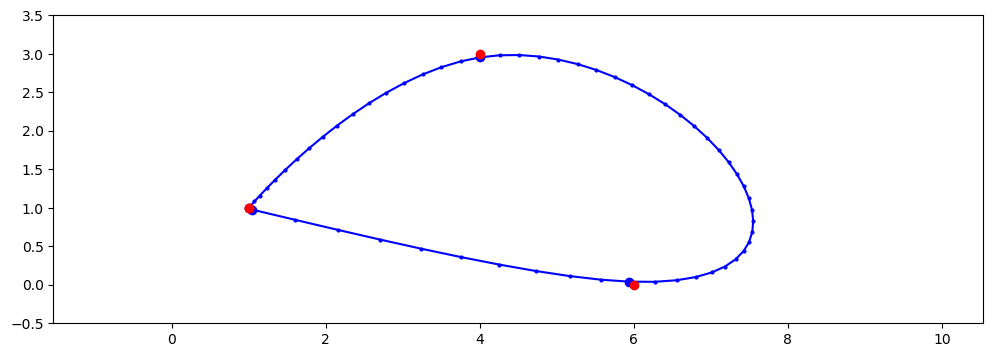

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 242 rows, 360 columns and 714 nonzeros
Model has 128 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 1e+00]
  QObjective range [2e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 234 rows and 236 columns
Presolve time: 0.00s
Presolved: 8 rows, 124 columns, 338 nonzeros
Presolved model has 122 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 124
 AA' NZ     : 1.200e+01
 Factor NZ  : 2.000e+01
 Factor Ops : 6.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.28348943e+00  6.29804140e+00  2.20e-16 2.40e+00  0.00e+00     0s
   1   4.12158380e-02  4.12335492e-02  4.08e-12 2.40e-06  0.00e+00   

In [8]:
λ = 0.1 # choose a value for λ
(y1x,y2x,x) = solveOpt(λ) # solve model with given λ

# plot the solution against the checkpoints
using PyPlot
figure(figsize=(12,4))
plot( x[1,:], x[2,:], "b.-", markersize=4 )
plot( x[1,:][T], x[2,:][T], "b.", markersize=12 )
plot( way_xy[1,:], way_xy[2,:], "r.", markersize=12 )
axis("equal")
axis((1.,8.,-.5,3.5));

## Compute tradeoff curve

Now let's compute the Pareto curve for many values of $\lambda$

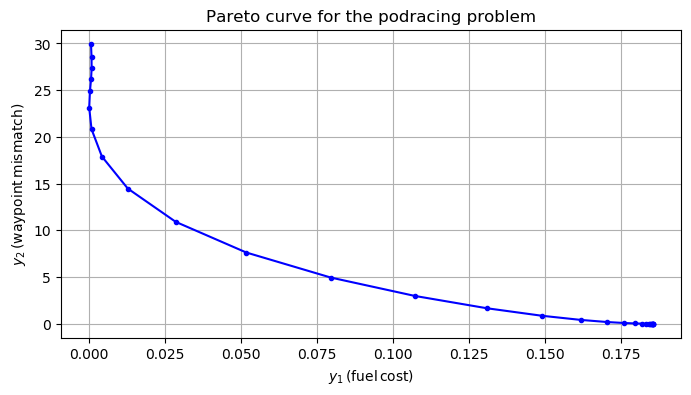

[9.999999999999999e-6, 1.610262027560939e-5, 2.592943797404667e-5, 4.1753189365604e-5, 6.723357536499335e-5, 0.00010826367338740541, 0.00017433288221999874, 0.0002807216203941176, 0.00045203536563602454, 0.0007278953843983154, 0.0011721022975334804, 0.0018873918221350976, 0.003039195382313198, 0.004893900918477494, 0.007880462815669913, 0.012689610031679222, 0.020433597178569417, 0.03290344562312668, 0.05298316906283707, 0.0853167852417281, 0.1373823795883263, 0.2212216291070449, 0.3562247890262442, 0.5736152510448679, 0.9236708571873862, 1.4873521072935114, 2.3950266199874855, 3.856620421163471, 6.2101694189156165, 10.0]
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 242 rows, 360 columns and 714 nonzeros
Model has 128 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e-04]
  QObjective range [2e-05, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range    

In [21]:
Npts = 30
y1 = zeros(Npts)
y2 = zeros(Npts)
println(10 .^(range(-5,stop=1,length=Npts)))
for (i,λ) in enumerate(10 .^(range(-5,stop=1,length=Npts)))
    (y1[i],y2[i],uu) = solveOpt(λ)
end;

# plot the points
using PyPlot
figure(figsize=(8,4))
plot( y1, y2, "b.-" )
xlabel(L"y_1\, (\sf fuel\, cost)")
ylabel(L"y_2\, (\sf waypoint\, mismatch)");
title("Pareto curve for the podracing problem")
grid()